In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchmetrics.functional as metrics
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
from torch.nn.init import kaiming_normal
from torchinfo import summary

In [25]:
# 이미지 사이즈 맞추고 텐서화
preprocessing = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    # ToTensor() -> 0~1의 값으로 정규화
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [26]:
img_root = '../data/image/SMALL'

dataDS = ImageFolder(root=img_root, transform=preprocessing)

In [27]:
dataDS.classes = [label.replace('_small', '') for label in dataDS.classes]

In [28]:
dataDS.class_to_idx = {new_class: idx for idx, new_class in enumerate(dataDS.classes)}

In [29]:
img = []
label = []
for image_path,la in dataDS.imgs:
    image = Image.open(image_path)
    image = preprocessing(image) 
    img.append(image)
    label.append(la)

In [30]:
x_train, x_val, y_train, y_val = train_test_split(img,label,test_size=0.1,stratify=label,random_state=4)

In [31]:
class DLDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.feature = x_data
        self.target = y_data

        
    def __len__(self):
        return len(self.feature)

    def __getitem__(self, index):
        image_tensor = self.feature[index]
        label = self.target[index]
        return image_tensor, label

In [32]:
trainDS = DLDataset(x_train,y_train)
validDS = DLDataset(x_val,y_val)

In [33]:
from collections import Counter # 요소의 개수 반환 : dict

# 클래스별 비율 계산
train_class = {label: count / len(trainDS) for label, count in Counter([label for _, label in trainDS]).items()}
valid_class = {label: count / len(validDS) for label, count in Counter([label for _, label in validDS]).items()}


train_class, valid_class 

({14: 0.04367357125031195,
  10: 0.03493885700024956,
  13: 0.04117793860743699,
  19: 0.04641876715747442,
  22: 0.03843274270027452,
  3: 0.03419016720738707,
  23: 0.03493885700024956,
  8: 0.04167706513601198,
  1: 0.04392313451459945,
  2: 0.038682305964562014,
  20: 0.04067881207886199,
  15: 0.0321936610930871,
  4: 0.044172697778886945,
  9: 0.053406538557524336,
  16: 0.049163963064636884,
  18: 0.04542051410032443,
  5: 0.031195408035937112,
  0: 0.03344147741452458,
  12: 0.03843274270027452,
  11: 0.034689293735962065,
  21: 0.03369104067881208,
  7: 0.044172697778886945,
  17: 0.04367357125031195,
  24: 0.03618667332168705,
  6: 0.04142750187172448},
 {3: 0.033632286995515695,
  6: 0.04035874439461883,
  11: 0.033632286995515695,
  7: 0.04484304932735426,
  17: 0.04484304932735426,
  5: 0.03139013452914798,
  13: 0.04035874439461883,
  22: 0.03811659192825112,
  14: 0.04484304932735426,
  2: 0.03811659192825112,
  23: 0.03587443946188341,
  16: 0.04932735426008968,
  9: 0.

In [34]:
SAMPLER = WeightedRandomSampler(weights=[train_class[label] for _,label in trainDS], num_samples=len(trainDS), replacement=True)

BATCH = 32
# DataLoader 생성
trainDL = DataLoader(trainDS, batch_size=BATCH, sampler=SAMPLER)
validDL = DataLoader(validDS, batch_size=BATCH)

In [35]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

EPOCHS = 1000

LF = nn.CrossEntropyLoss()

In [36]:
model = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1)

# 전결합층 변경
# in_features : FeatureMap에서 받은 피쳐수, out_features : 출력/분류 클래스 수
model.fc = nn.Linear(in_features=512, out_features=len(dataDS.classes))

In [37]:
# Resnet18 Feature Module 파라미터 requires_grad = True => False 비활성화
for name, param in model.named_parameters():
    param.requires_grad = False

# Resnet18 Full Connected Module 파라미터 requires_grad = False => True 활성화
for name, param in model.fc.named_parameters():
    param.requires_grad = True

In [38]:
rOPTIMIZER = torch.optim.Adam(model.fc.parameters(), lr = 0.001)

rSCHEDULER = ReduceLROnPlateau(rOPTIMIZER, mode = 'min', patience = 3)

In [39]:
r_train_report = [[],[]]
r_val_report = [[],[]]
minLoss = 100
for epoch in range(1,EPOCHS+1):
    print(f'[EPOCH: {epoch}]')
    
    model.train()
    tlossList = []
    taccList = []

    for (img,label) in trainDL:
        img = img.to(DEVICE)
        rOPTIMIZER.zero_grad()
        output = model(img)
        loss = LF(output, label)
        loss.backward()
        rOPTIMIZER.step()
        f1 = metrics.f1_score(output, label,task='multiclass', num_classes= len(dataDS.classes) )
        tlossList.append(loss.item())
        taccList.append(f1)
    train_loss = sum(tlossList)/len(tlossList)
    train_acc = sum(taccList)/len(taccList)
    print(f"Train Loss : {train_loss:.4f}, \tTrain Accuracy : {train_acc:.2f} ")
        
    model.eval()
    
    vlossList = []
    vaccList = []
    
    with torch.no_grad():
        for (img,label) in validDL:
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            output = model(img)
            loss = LF(output, label)
            vlossList.append(loss.item())
            _, preds = torch.max(output, 1)
            f1 = metrics.f1_score(label, preds,task = 'multiclass', num_classes=len(dataDS.classes)) 
            vaccList.append(f1)
        valid_loss = sum(vlossList)/len(vlossList)
        valid_acc = sum(vaccList)/len(vaccList)
        print(f"Test Loss : {valid_loss:.4f}, \t Test Accuracy : {valid_acc:.2f} ")
        
    r_train_report[0].append(train_loss)
    r_train_report[1].append(train_acc)
    r_val_report[0].append(valid_loss)
    r_val_report[1].append(valid_acc)
    
    rSCHEDULER.step(valid_loss)
    
    if valid_loss < minLoss:
        minLoss = valid_loss
        torch.save(model.state_dict(), 'model/res_smallDogModel.pth')
        
    if rSCHEDULER.num_bad_epochs >= rSCHEDULER.patience:
        print(f'조기 종료 at epoch {epoch}')
        break

[EPOCH: 1]
Train Loss : 1.7676, 	Train Accuracy : 0.55 
Test Loss : 1.0061, 	 Test Accuracy : 0.73 
[EPOCH: 2]
Train Loss : 0.8512, 	Train Accuracy : 0.78 
Test Loss : 0.7269, 	 Test Accuracy : 0.77 
[EPOCH: 3]
Train Loss : 0.6643, 	Train Accuracy : 0.82 
Test Loss : 0.6259, 	 Test Accuracy : 0.78 
[EPOCH: 4]
Train Loss : 0.5667, 	Train Accuracy : 0.84 
Test Loss : 0.5879, 	 Test Accuracy : 0.79 
[EPOCH: 5]
Train Loss : 0.5098, 	Train Accuracy : 0.84 
Test Loss : 0.5675, 	 Test Accuracy : 0.79 
[EPOCH: 6]
Train Loss : 0.4551, 	Train Accuracy : 0.87 
Test Loss : 0.5298, 	 Test Accuracy : 0.81 
[EPOCH: 7]
Train Loss : 0.4380, 	Train Accuracy : 0.87 
Test Loss : 0.5251, 	 Test Accuracy : 0.82 
[EPOCH: 8]
Train Loss : 0.4224, 	Train Accuracy : 0.88 
Test Loss : 0.5251, 	 Test Accuracy : 0.81 
[EPOCH: 9]
Train Loss : 0.4069, 	Train Accuracy : 0.88 
Test Loss : 0.5067, 	 Test Accuracy : 0.84 
[EPOCH: 10]
Train Loss : 0.3686, 	Train Accuracy : 0.88 
Test Loss : 0.4802, 	 Test Accuracy : 0.83 

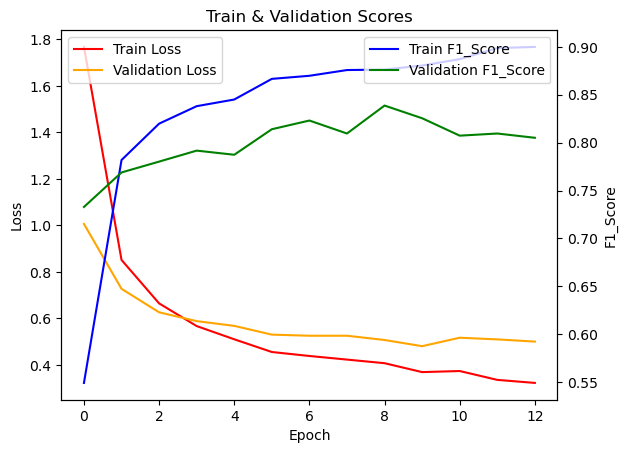

In [41]:
fig, ax1 = plt.subplots()  


ax1.plot(r_train_report[0], label='Train Loss', color='red')
ax1.plot(r_val_report[0], label='Validation Loss', color='orange')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(r_train_report[1], label='Train F1_Score', color='blue')
ax2.plot(r_val_report[1], label='Validation F1_Score', color='green')
ax2.set_ylabel('F1_Score')
ax2.set_xlabel('Epoch')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.xlabel('Epoch')  
plt.title('Train & Validation Scores')
plt.show()